# CPC Wrfcf Bias 2017-02-05 to 2017-02-17

In [1]:
# imports
import numpy
import Nio
import Ngl
from IPython import display
import netCDF4 as nc
from datetime import date
from datetime import timedelta
import xarray as xr
import xesmf as xe
import pandas as pd

In [9]:
# read in daily difference datasets
dif_05 = xr.open_dataarray('./dif_05_cpc-Copy1.nc')
dif_06 = xr.open_dataarray('./dif_06_cpc-Copy1.nc')
dif_07 = xr.open_dataarray('./dif_07_cpc-Copy1.nc')
dif_08 = xr.open_dataarray('./dif_08_cpc-Copy1.nc')
dif_09 = xr.open_dataarray('./dif_09_cpc-Copy1.nc')
dif_10 = xr.open_dataarray('./dif_10_cpc-Copy1.nc')
dif_11 = xr.open_dataarray('./dif_11_cpc-Copy1.nc')
dif_12 = xr.open_dataarray('./dif_12_cpc-Copy1.nc')
dif_13 = xr.open_dataarray('./dif_13_cpc-Copy1.nc')
dif_14 = xr.open_dataarray('./dif_14_cpc-Copy1.nc')
dif_15 = xr.open_dataarray('./dif_15_cpc-Copy1.nc')
#dif_16 = xr.open_dataarray('./dif_16_prev-Copy1.nc')
#dif_17 = xr.open_dataarray('./dif_17-Copy1.nc')

# define dictionary
#dif_dict = {5:dif_05, 6:dif_06, 7:dif_07, 8:dif_08, 9:dif_09, 
            #10:dif_10, 11:dif_11, 12:dif_12, 13:dif_13, 14:dif_14, 
            #15:dif_15, 16:dif_16, 17:dif_17}
dif_dict = {5:dif_05, 6:dif_06, 7:dif_07, 8:dif_08, 9:dif_09, 
            10:dif_10, 11:dif_11, 12:dif_12, 13:dif_13, 14:dif_14, 
            15:dif_15}
sum(~numpy.isnan(dif_05.data.flatten()))

2041

In [3]:
# average the difference over the 13 days, returns DataArray object
def bias_arr():
    next_key = 6
    temp = dif_dict[5].data.flatten()
    while next_key <= 15: #17
        arr1 = temp
        arr2 = dif_dict[next_key].data.flatten()
        next_key += 1
        temp = numpy.add(arr1, arr2)
    bias = temp / 11 #13
    return bias

bias_out = bias_arr()
bias_out = numpy.array_split(bias_out, 360)
lat_coord = dif_dict[6]['lat'].data.flatten()
lon_coord = dif_dict[6]['lon'].data.flatten()
bias_out = xr.DataArray(bias_out, coords = [lat_coord, lon_coord], dims = ['lat', 'lon'])
bias_out

<xarray.DataArray (lat: 360, lon: 720)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat      (lat) float32 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float32 -359.8 -359.2 -358.8 -358.2 ... -1.25 -0.75 -0.25

In [4]:
# some values for reference
numpy.unique(bias_out), max(numpy.unique(bias_out)), min(numpy.unique(bias_out))

(array([-9.91094218, -9.86865653, -9.52562526, ...,         nan,
                nan,         nan]),
 5.313334877349255,
 -9.91094217506514)

In [5]:
# save as a nc file for later
bias_out.to_netcdf('./bias_17_cpc.nc')

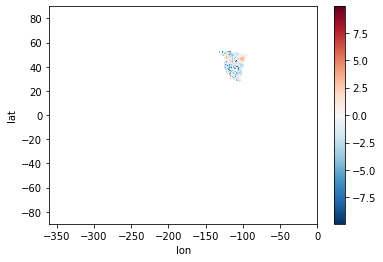

In [6]:
# test plot
bias_out.plot()

In [7]:
# convert dif_arr to masked array to overlook NaNs
import numpy.ma as ma
m_out = ma.masked_invalid(bias_out.data)
m_out

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=1e+20)

In [8]:
# numerical data, mean bias over entire region
numpy.mean(m_out)

-1.1440197183390788

# workstation
wks_type2 = "png"
wks2 = Ngl.open_wks(wks_type2,"17_bias_NG-GR-NQ-BD")

# borrow RHS plot end coords
fn = '/cw3e/mead/projects/cwp103/production/output/2017020500/cf/NG-GR-NQ-BD/wrfcf_d02_2017-02-05_22_00_00.nc'
da_input = xr.open_dataset(fn)

# defining variables
temp = m_out
lat = bias_out['lat'].data.flatten()
lon = bias_out['lon'].data.flatten()
lat2 = da_input['lat'].data.flatten()
lon2 = da_input['lon'].data.flatten()
tmax_nlat = len(lat)
tmax_nlon = len(lon)

# XY of overlay plot
resources = Ngl.Resources()
resources.sfXCStartV = min(lon)
resources.sfXCEndV   = max(lon)
resources.sfYCStartV = min(lat)
resources.sfYCEndV   = max(lat)

# fill missing values as needed
if hasattr(temp,"_FillValue"):
    resources.sfMissingValueV = temp[0]._FillValue

# color map (sensitive to smaller values)
cmap = ['Ghostwhite', 'Grey0', 
        'Purple4', 'RoyalBlue3', 'RoyalBlue1', 'DeepSkyBlue', 'Cyan', 'DarkTurquoise', 
        'SeaGreen2', 'SpringGreen', 'Chartreuse', 'GreenYellow', 'OliveDrab2', 'Yellow', 
        'Gold', 'Orange', 'DarkOrange', 'Red', 'Red']

# plot styling
resources.wkColorMap = cmap
Ngl.set_values(wks2,resources)
resources.cnLevelSelectionMode = "ManualLevels"
resources.cnMinLevelValF       = -7
resources.cnMaxLevelValF       = 7
resources.cnLevelSpacingF      = 1
resources.tiXAxisString = "~F25~Longitude"
resources.tiYAxisString = "~F25~Latitude"
resources.cnFillOn              = True    
resources.cnLineLabelsOn        = False  
resources.cnInfoLabelOn         = False  
resources.nglSpreadColorEnd     = -2
resources.mpProjection = "LambertEqualArea" 
resources.mpCenterLonF = (lon[tmax_nlon-1] + lon[0])/2
resources.mpCenterLatF = (lat[tmax_nlat-1] + lat[0])/2
resources.mpLimitMode = "LatLon"
resources.mpMinLonF   = min(lon2)
resources.mpMaxLonF   = max(lon2)
resources.mpMinLatF   = min(lat2)
resources.mpMaxLatF   = max(lat2)
resources.mpOutlineBoundarySets = "GeophysicalAndUSStates"
resources.mpPerimOn   = True
resources.cnLinesOn   = False
resources.pmTickMarkDisplayMode = "Never"
resources.tiMainString = "~F26~Wrfcf, Livneh Bias, 2017-02-05 to 2017-02-17, NG-GR-NQ-BD"
resources.lbOrientation  = "Horizontal"
resources.lbTitleString  = "~F25~Temp (C)" 

# plot
map = Ngl.contour_map(wks2,temp,resources)

# clean up
del map
del resources
Ngl.end()

# display plot
display.Image("./17_bias_NG-GR-NQ-BD.png")